### Full - Baseline : Statistical Features + GRU

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

import random

from scipy.stats import kurtosis, skew

import sys
from datetime import datetime

In [16]:
# check GPU setting
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090 Ti


In [17]:
# function to set random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed_all(seed)

     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)

     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [18]:
# function to get statistics
def get_stat(data, lenth=316):
    slices = torch.split(data, lenth, dim=0)
    all_stat = []
    for slice in slices:
        means = torch.mean(slice, dim=0)
        stds = torch.std(slice, dim=0)
        medians = torch.median(slice, dim=0).values
        mins = torch.min(slice, dim=0).values
        maxs = torch.max(slice, dim=0).values
        kurts = torch.from_numpy(kurtosis(slice.numpy(), axis=0))
        skews = torch.from_numpy(skew(slice.numpy(), axis=0))
        stats = torch.cat([means, stds, medians, mins, maxs, skews, kurts])
        all_stat.append(stats)
    all_stat = torch.stack(all_stat)
    all_stat = torch.nan_to_num(all_stat, nan=0.0)

    return all_stat

In [19]:
# transfer raw data to dataset class
class myDataset(Dataset):
    def __init__(self, raw_data, past_wafer):
        self.raw_data = raw_data

        x_data = np.array(raw_data)[:, :-1]
        labels = np.array(raw_data)[:, -1]

        data = x_data
        data = torch.tensor(data).double()
        labels = torch.tensor(labels).double()

        x_arr, y_arr, z_arr = [], [], []
        total_time_len, node_num,  = data.shape
        wafer_len = 316
        past_wafer_len = 316 * past_wafer
        rang = range(past_wafer_len, total_time_len, wafer_len)
        for i in rang:
            ft = data[i-past_wafer_len:i, :]
            stats = get_stat(ft)
            x_arr.append(stats)
            y_arr.append(labels[i])
            mrr = labels[i-past_wafer_len:i]
            mrr = torch.unique_consecutive(mrr)
            z_arr.append(mrr)
        
        self.x = torch.stack(x_arr).contiguous()
        self.y = torch.stack(y_arr).contiguous()
        self.z = torch.stack(z_arr).contiguous()
        self.len = len(x_arr)

    def __getitem__(self, idx):

        x = self.x[idx].double()
        y = self.y[idx].double()
        z = self.z[idx].double()

        return x, y, z
    
    def __len__(self):
        return self.len

In [20]:
# model building
class Stats_GRU(nn.Module):
    def __init__(self, input_dim, inter_dim, layer_num, past_wafer):
        super(Stats_GRU, self).__init__()
        self.inter_dim = inter_dim
        self.layer_num = layer_num

        self.bn = nn.BatchNorm1d(input_dim)

        # define GRU layer
        self.gru = nn.GRU(input_dim, inter_dim, layer_num, batch_first=True)

        # define MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(inter_dim+past_wafer, 1),
            nn.ReLU())

    def forward(self, x, mrr):
        # initialize original memory
        h0 = torch.zeros(self.layer_num, x.size(0), self.inter_dim).double().to(x.device)

        # forward propagation，x size (batch_size, sequence_length, input_dim)
        out, _ = self.gru(x, h0)

        # retain the last memory
        out = out[:, -1, :]

        # concat past MRR
        out = torch.hstack((out, mrr))

        # go through MLP layer
        out = self.mlp(out)

        return out.squeeze(1)

In [21]:
# split out the validation set and transfer into dataloaders
def get_loaders(train_dataset, seed, batch_size, val_ratio=0.1):
    
    dataset_len = int(len(train_dataset))
    train_use_len = int(dataset_len * (1 - val_ratio))
    val_use_len = int(dataset_len * val_ratio)
    val_start_index = random.randrange(train_use_len)
    indices = torch.arange(dataset_len)

    train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
    train_subset = Subset(train_dataset, train_sub_indices)

    val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
    val_subset = Subset(train_dataset, val_sub_indices)

    train_dataloader = DataLoader(train_subset, batch_size,
                            shuffle=False)

    val_dataloader = DataLoader(val_subset, batch_size,
                            shuffle=False)

    return train_dataloader, val_dataloader

In [22]:
def test(model, test_dataloader, device):
    
    model.eval()

    test_pred_list = []
    test_ground_list = []
    loss_list = []

    for x, y, z in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)

        with torch.no_grad():

            model = model.double()
            out = model(x, z).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            test_pred_list.extend(out.detach().cpu().tolist())
            test_ground_list.extend(y.detach().cpu().tolist())
            

        loss_list.append(loss.detach().cpu().item())
    
    avg_loss = sum(loss_list)/len(loss_list)

    return avg_loss, [test_pred_list, test_ground_list] 

In [23]:
def train(model, train_dataloader, val_dataloader, optimizer, epoch, device, path):
    
    min_loss = 1e+8
    early_stop_win = 30

    for i_epoch in range(epoch):

        loss_list= []
        acu_loss = 0
        model.train()

        for x, y, z in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            
            optimizer.zero_grad()
            model = model.double()
            out = model(x, z).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())
            acu_loss += loss.item()

        val_loss, _ = test(model, val_dataloader, 'cuda')

        if val_dataloader is not None:

            val_loss, val_result = test(model, val_dataloader, 'cuda')

            if val_loss < min_loss:
                torch.save(model.state_dict(), path)

                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            if acu_loss < min_loss:
                torch.save(model.state_dict(), path)
                min_loss = acu_loss

        # each epoch
        print(
            'epoch ({} / {}) (Train_loss:{:.8f}, ACU_loss:{:.8f}, Val_loss:{:.8f})'
            .format(
                i_epoch + 1,
                epoch,
                acu_loss / len(train_dataloader),
                acu_loss,
                val_loss,
            ),
            flush=True)

A456

In [24]:
# training setting
dataset = 'A456'
batch_size = 256
input_dim = 19 * 7
inter_dim = 64
layer_num = 3
past_wafer = 4
val_ratio = 0.2
seed = 2

# set random seed
setup_seed(seed)

In [ ]:
# get training and testing dataset
train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
# concat the past wafer referenced from training set
test_extend = pd.concat((train_orig.iloc[-(316 * past_wafer):,:], test_orig))

train_dataset = myDataset(train_orig, past_wafer)
test_dataset = myDataset(test_extend, past_wafer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = Stats_GRU(input_dim, inter_dim, layer_num, past_wafer).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/Stats_GRU/best_{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 1000, 'cuda', save_path)

C:\Users\Lakers\AppData\Local\Temp\ipykernel_27348\2536148298.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts = torch.from_numpy(kurtosis(slice.numpy(), axis=0))
C:\Users\Lakers\AppData\Local\Temp\ipykernel_27348\2536148298.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews = torch.from_numpy(skew(slice.numpy(), axis=0))


epoch (1 / 1000) (Train_loss:3236.95690221, ACU_loss:9710.87070663, Val_loss:3029.78302495)
epoch (2 / 1000) (Train_loss:3083.59256690, ACU_loss:9250.77770071, Val_loss:2879.60174760)
epoch (3 / 1000) (Train_loss:2926.92996893, ACU_loss:8780.78990678, Val_loss:2721.33922780)
epoch (4 / 1000) (Train_loss:2761.46992117, ACU_loss:8284.40976350, Val_loss:2556.56902509)
epoch (5 / 1000) (Train_loss:2592.58927951, ACU_loss:7777.76783854, Val_loss:2396.31202809)
epoch (6 / 1000) (Train_loss:2432.90984653, ACU_loss:7298.72953960, Val_loss:2252.28054681)
epoch (7 / 1000) (Train_loss:2291.76923998, ACU_loss:6875.30771995, Val_loss:2127.53374138)
epoch (8 / 1000) (Train_loss:2169.30244750, ACU_loss:6507.90734251, Val_loss:2018.14721515)
epoch (9 / 1000) (Train_loss:2060.75164577, ACU_loss:6182.25493732, Val_loss:1919.18591152)
epoch (10 / 1000) (Train_loss:1961.48580750, ACU_loss:5884.45742250, Val_loss:1827.10749822)
epoch (11 / 1000) (Train_loss:1868.42752878, ACU_loss:5605.28258633, Val_loss:1

MSE :  7.950076762163486


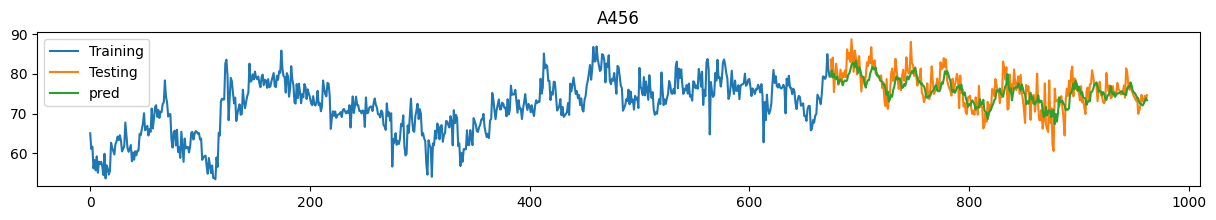

In [26]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', avg_loss)

# plot the result
y_train = [train_orig['MRR'][i] for i in range(0, len(train_orig), 316)]
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Training')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Testing')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()

B456

In [27]:
# training setting
dataset = 'B456'
batch_size = 256
input_dim = 19 * 7
inter_dim = 8
layer_num = 2
past_wafer = 4
val_ratio = 0.2
seed = 2

# set random seed
setup_seed(seed)

In [ ]:
# get training and testing dataset
train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
# concat the past wafer referenced from training set
test_extend = pd.concat((train_orig.iloc[-(316 * past_wafer):,:], test_orig))

train_dataset = myDataset(train_orig, past_wafer)
test_dataset = myDataset(test_extend, past_wafer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = Stats_GRU(input_dim, inter_dim, layer_num, past_wafer).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/Stats_GRU/best_{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

C:\Users\Lakers\AppData\Local\Temp\ipykernel_2872\2536148298.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts = torch.from_numpy(kurtosis(slice.numpy(), axis=0))
C:\Users\Lakers\AppData\Local\Temp\ipykernel_2872\2536148298.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews = torch.from_numpy(skew(slice.numpy(), axis=0))


epoch (1 / 2000) (Train_loss:3443.39512953, ACU_loss:10330.18538859, Val_loss:3137.83037581)
epoch (2 / 2000) (Train_loss:3330.88746462, ACU_loss:9992.66239386, Val_loss:3034.71991795)
epoch (3 / 2000) (Train_loss:3220.74140345, ACU_loss:9662.22421034, Val_loss:2933.68198550)
epoch (4 / 2000) (Train_loss:3112.86603201, ACU_loss:9338.59809602, Val_loss:2834.73277229)
epoch (5 / 2000) (Train_loss:3007.24628551, ACU_loss:9021.73885653, Val_loss:2737.87855586)
epoch (6 / 2000) (Train_loss:2903.87871273, ACU_loss:8711.63613818, Val_loss:2643.12628418)
epoch (7 / 2000) (Train_loss:2802.76849893, ACU_loss:8408.30549679, Val_loss:2550.48500836)
epoch (8 / 2000) (Train_loss:2703.91918090, ACU_loss:8111.75754269, Val_loss:2459.96851794)
epoch (9 / 2000) (Train_loss:2607.34176022, ACU_loss:7822.02528066, Val_loss:2371.59415984)
epoch (10 / 2000) (Train_loss:2513.04789219, ACU_loss:7539.14367656, Val_loss:2285.37525939)
epoch (11 / 2000) (Train_loss:2421.04988615, ACU_loss:7263.14965846, Val_loss:

MSE :  14.460930626294228


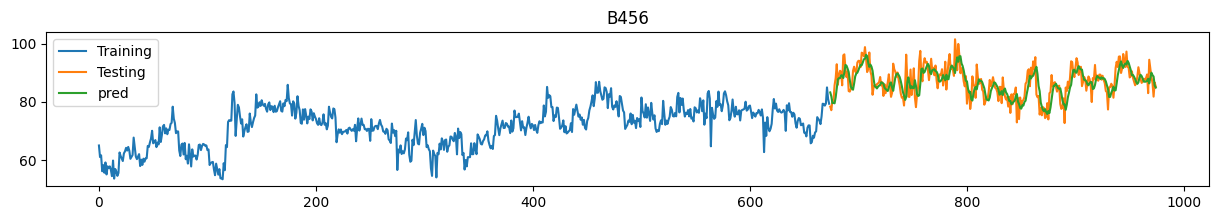

In [ ]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', avg_loss)

# plot the result
y_train = [train_orig['MRR'][i] for i in range(0, len(train_orig), 316)]
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Training')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Testing')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()